## This notebook is part of the Spark training delivered by IT-DB group
### Regression with spark.ml
by Riccardo Castellotti

This notebook is an implementation of a well-known regression system training with `spark.ml`.


This data was initially featured in the following paper: Pace, R. Kelley, and Ronald Barry. "Sparse spatial autoregressions." Statistics & Probability Letters 33.3 (1997): 291-297, and the steps we follow in this notebook are inspired by the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition".


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("ML HandsOn 2") \
        .getOrCreate()

In [21]:
df=spark.read\
    .format("csv")\
    .option("header","true")\
    .option("inferschema","true")\
    .load("../data/housing.csv.gz")

train, test = df.randomSplit([0.8,0.2])

In [14]:
train.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [22]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorIndexer,Imputer,VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

In [16]:
ocean_index=StringIndexer(inputCol="ocean_proximity",outputCol="indexed_ocean_proximity")
ocean_onehot=OneHotEncoder(inputCol="indexed_ocean_proximity",outputCol="oh_ocean_proximity")
ocean_scaled=VectorIndexer(inputCol="oh_ocean_proximity",outputCol="final_ocean_proximity",maxCategories=5)
imputer_tot_br=Imputer(strategy='median',inputCols=["total_bedrooms"],outputCols=["total_bedrooms_filled"])

features=["longitude", "latitude", "housing_median_age", 
            "total_rooms", "population", "households", 
            "median_income", "final_ocean_proximity", "total_bedrooms_filled"]

features_correlation=["longitude", "latitude", "housing_median_age", 
            "total_rooms", "population", "households", 
            "median_income", "total_bedrooms_filled"]
                          
assembler=VectorAssembler(inputCols=features,
                                     outputCol="unscaled_features")


std_scaler=StandardScaler(inputCol="unscaled_features", outputCol="features")

regressor=GBTRegressor(labelCol="median_house_value",maxIter=40)

pipeline=Pipeline(stages=[ocean_index,ocean_onehot,ocean_scaled,imputer_tot_br,assembler,std_scaler,regressor])


An example of crossvalidation and grid search (change the grid type to "code" to run it.

In [26]:
model=pipeline.fit(train)
model_correlation=pipeline.fit(train,params={assembler.inputCols:features_correlation})

#model_correlation=pipeline_for_correlation.fit(train)

train_transformed=model.transform(train)
train_correlation=model_correlation.transform(train)

In [27]:
from pyspark.ml.stat import Correlation

matrix = Correlation.corr(train_correlation.select('features'), 'features')
matrix_np = matrix.collect()[0]["pearson({})".format('features')].values

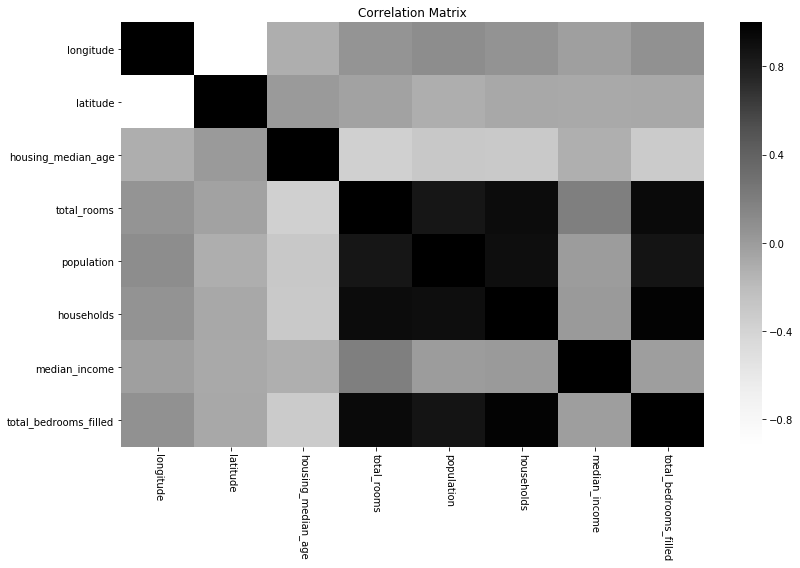

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 

matrix_np = matrix_np.reshape(8,8)

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(matrix_np, cmap="Greys")
ax.xaxis.set_ticklabels(features_correlation, rotation=270)
ax.yaxis.set_ticklabels(features_correlation, rotation=0)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [20]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 55101.7
